In [ ]:
# ISSUES
# [] Price and value balance
# [] What types of traders to introduce?
# [] How best to model perceived value? 

# Limitations
# Only one type of trader exists
# The model is not modelled on a buyer/seller interaction scheme, 
#     rather each trader can buy or sell whenever they'd desire
#     and their assets will be liquidised immediately.

# Are Stock Markets Self Organising Criticalities?

### Aim 



### 2. Methodology
 
#### 2.1. Environment Definition
The environemnt can be defined in two elements: a list of stock options, with their respective perceived values and current prices, and the market index.

##### Variables:
- Stock price
- Stock value
- Stock risk 
- Stock outstanding shares
- Index, calculated as follows: todays_index = ((stock_prices/stocks) / last_days_index ) * 1000

##### Change Events
There are sporadic events that can cause the stock's value to go up or down (e.g. company earnings disclosure, Warren Buffet acquisition news, scandals, etc.)

#### 2.2. Agent Definition
An agent is a trader in a stock market context.

###### 2.2.3. Day Trader 
This agent is the most active and most volatile of all traders.

###### 2.2.4.  Strategy
Traders who follow the Barbell Strategy divide their investments between low risk and high risk stocks. They avoid the unsafe medium-risk low-payoff options and stick with either safe low-risk or high-risk big payoff stock options. 

#### 2.3. Behaviour Definition
##### 2.3.1. Agent Buying
##### 2.3.2. Agent Selling

#### 2.4. Metrics
##### 2.4.1. Market Index
##### 2.4.2. Wealth Distribution

 

In [98]:
%matplotlib inline

import random
import threading
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt, mpld3
import seaborn as sns

class InvalidOperation(Exception):
    pass

class Stock:
    def __init__(self, id, price, value, count, risk):
        self.id = id
        self.price = value * random.gauss(1,0.0001)
        self.value = value
        self.count = count
        self.risk = risk
        
        # trends
        self.price_trend = [self.price]
        self.value_trend = [value]
        

    def buy(self):
        if not self.count:
            raise InvalidOperation
        self.count -= 1
        self.price *= 1.001
        self.price_trend.append(self.price) 
        self.value_trend.append(self.value)

    def sell(self):
        self.count += 1
        self.price *= 0.99999
        self.price_trend.append(self.price) 
        self.value_trend.append(self.value)
        
    def change(self):
        if random.random() < self.risk and self.value > 1:
            flate = random.gauss(1,0.001)
            self.value *= flate if flate >0 else 1
            self.price = self.value * random.gauss(1,0.0001)
            
    def __repr__(self):
        return f'{self.__class__.__name__}({self.id}, {self.price}, {self.value}, {self.count})'



class Trader:
    def __init__(self, id, wallet, appetite, stocks):
        self.id = id
        self.wallet = wallet
        self.portfolio = {stock.id: [0, stock.value] for stock in stocks}
        self.appetite = appetite



    def assess(self, stock):
        # a trader has a chance of 
        if random.random() < 0.2 and stock.risk <= self.appetite + 0.1:
            if stock.price <= stock.value: 
                self.buy(stock)
            else: 
                 self.sell(stock)
        stock.change()



    def buy(self, stock):
        if self.wallet > stock.price and stock.count > 0:
            i = str('[' +  str(id(self)) + ']' + ' buying ' + str(stock))
            #print(i)
            self.wallet -= stock.price
            self.portfolio[stock.id][0] += 1
            stock.buy()


    def sell(self, stock):
        if self.portfolio[stock.id][0] > 0:
            i = str('[' +  str(id(self)) + ']' + ' selling ' + str(stock))
            #print(i)
            self.wallet += stock.price
            self.portfolio[stock.id][0] -= 1
            stock.sell()
    
    # this function is no longer in use
    def liquidity(self):
        if random.random() < 0.1:
            self.wallet += random.gauss(500,20)
    
    
    # for visualisation
    def __repr__(self):
        return f'{self.__class__.__name__}({self.id}, {self.wallet}, {self.portfolio})'



def run_trader(trader, stocks, barrier, mutex):
    for stock in stocks:
        with mutex:
            # Ensuring that a single trader take a decision at a time
            trader.assess(stock)
        # Everyone will get to evaluate this stock option before
        # going to the next,
        barrier.wait()


def calculate_index(stocks, traders, index, method = 'price_weighted_average'):
    if method == 'price_weighted_average':
        prices = 0
        for stock in stocks:
             prices += stock.price
        
        ind = prices / 20
        index.append(ind)
    


In [157]:
### UTIL ###

def plot(market):
    fig = plt.figure(figsize=(14,14))
    r = sns.heatmap(market, cmap='BuPu',annot=True, fmt='.1f')
    r.set_title("Heatmap of Market")
    plt.show()
    plt.clf()

def sub_plot(market):
    fig = plt.figure(figsize=(7,14))
    r = sns.heatmap(market, cmap='YlGnBu',annot=True, fmt='.1f')
    r.set_title("Heatmap of Market")
    plt.show()
    plt.clf()


def represent(traders,stocks,index,duration):
    # displaying traders' portfolios
    colnames = [ 'total_assets', 'wallet']
    rownames = [ 'shares','perceived_value','current_price']
    for i in range(len(stocks)):
        colnames.append('stock_' + str(i+1))
    for o in range(len(traders)):
        rownames.append('trader_' + str(o+1))
    
    market = pd.DataFrame(0, index=rownames, columns=colnames)
    

    for stock in stocks:
        market.loc[str('shares'), str('stock_' + str(stock.id + 1))] = stock.count
        market.loc[str('perceived_value'), str('stock_' + str(stock.id + 1))] = stock.value
        market.loc[str('current_price'), str('stock_' + str(stock.id + 1))] = stock.price
        
    for trader in traders:
        assets = 0
        for stock in stocks:
            market.loc[str('trader_' + str(trader.id + 1)), 
                       str('stock_' + str(stock.id + 1))] = trader.portfolio[stock.id][0] * stock.price
            assets += trader.portfolio[stock.id][0] * stock.price
        # displaying traders' total values
        market.loc[str('trader_' + str(trader.id + 1)), str('total_assets')] = assets + trader.wallet
        # displaying trader wallets
        market.loc[str('trader_' + str(trader.id + 1)), str('wallet')] = trader.wallet
    
    plot(market)
     
    # plotting stock value 
    for stock in stocks:
        plt.plot(range(0,len(stock.price_trend)),stock.price_trend)
        plt.plot(range(0,len(stock.value_trend)),stock.value_trend)
        plt.title(str('Stock ' + str(stock.id)))
        plt.legend(['Price','Perceived Value'], loc='upper left')
        plt.show()
        mpld3.show()
        plt.clf()
    
    # plotting market index
    plt.plot(range(1,len(index)),index[1:])
    plt.show()
    plt.clf() #mpld3.show()
    

    
    # plotting Wealth Distribution
    market[3:]['total_assets'].plot.hist(bins=30)
    
    return market



## Stock Market Simulation

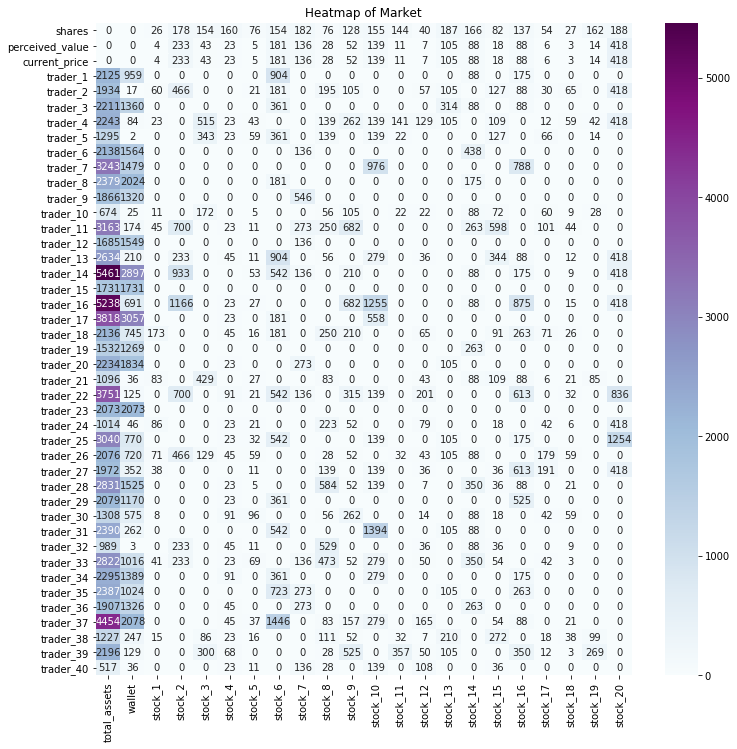

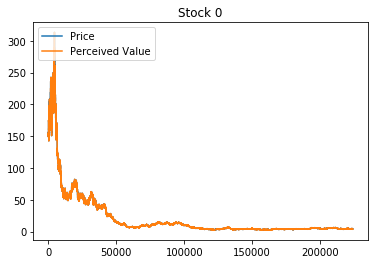

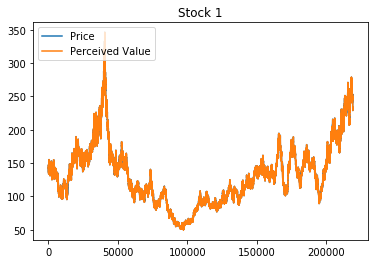

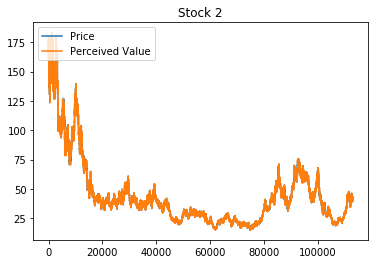

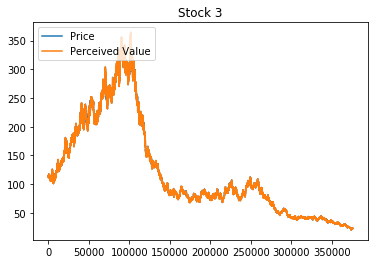

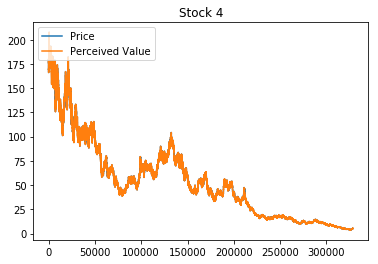

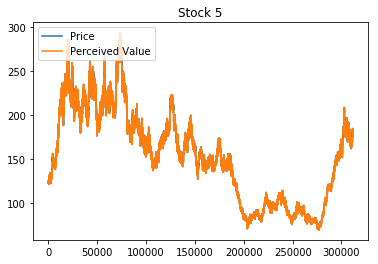

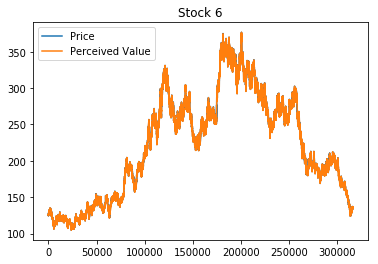

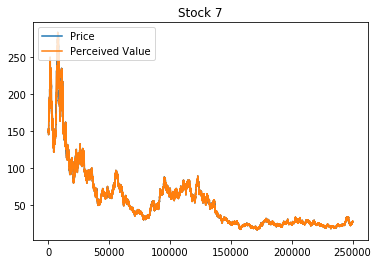

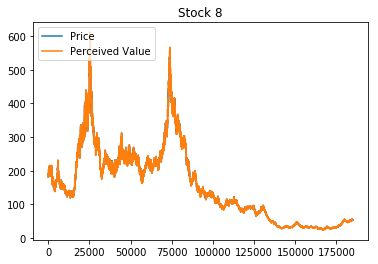

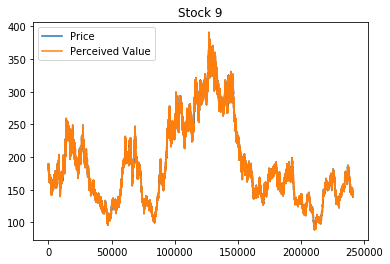

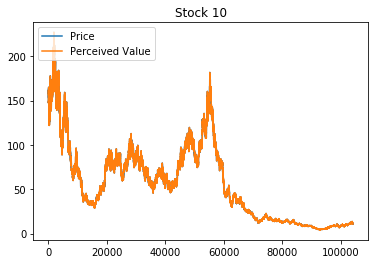

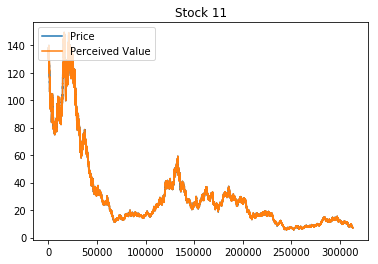

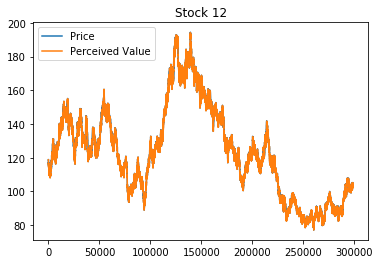

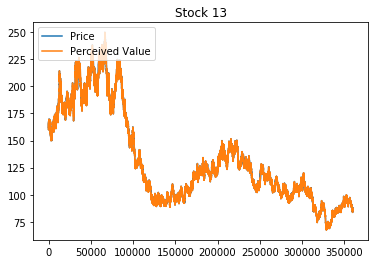

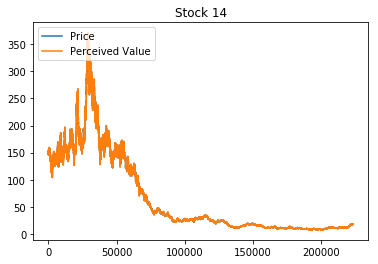

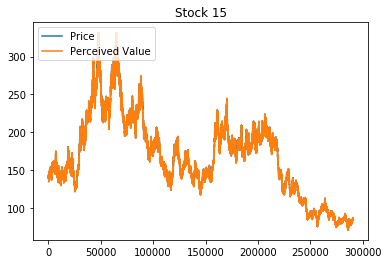

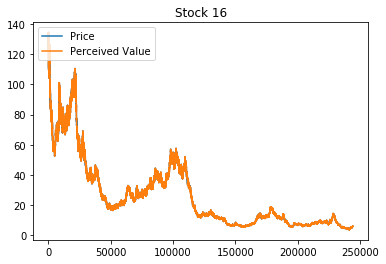

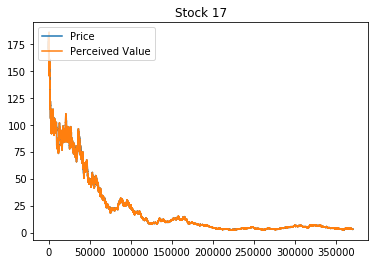

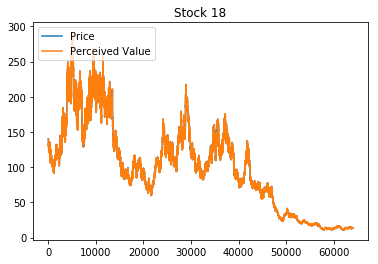

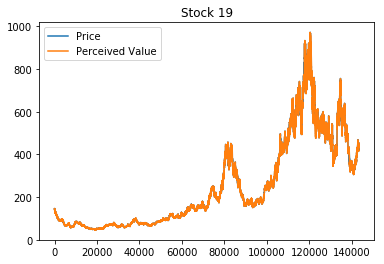

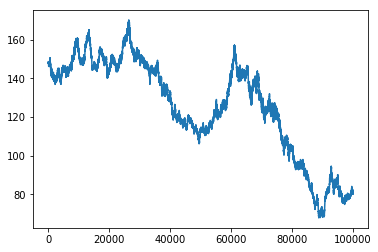

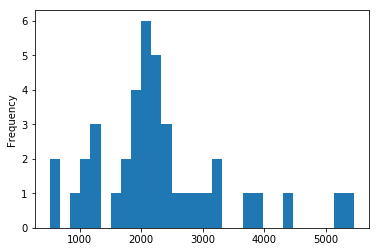

In [126]:
### RUN SIMULATION ###


def run_market(stocks, traders=40, duration=100000):
    mutex = threading.Lock()
    barrier = threading.Barrier(traders)

    # initialising index
    index = []
    price = 0
    for stock in stocks:
        price += stock.price
    index.append(price / 20)
    
    # initialising traders
    traders = [
            Trader(i,random.normalvariate(1000, 50), random.uniform(0.1,1), stocks)
            for i in range(traders)
    ]

    for time in range(duration):
        #print('time', time, 'starting')
        traders_threads = [
                threading.Thread(
                    target=run_trader,
                    args=(trader, stocks, barrier, mutex),
                ) for trader in traders
        ]
        for thread in traders_threads:
            thread.start()
        for thread in traders_threads:
            thread.join()

        #print('time', time, 'ending')
        calculate_index(stocks, traders, index)
    
    market = represent(traders,stocks,index,duration)
    return index, traders, stocks, market


def build_stocks(stocks=20):
    return [
            Stock(
                i,
                # stock price variation
                random.normalvariate(100, 4),
                # stock value variation
                random.normalvariate(150, 20),
                # stock outstanding shares
                random.randint(200, 200),
                # stock beta parameter for risk profiling 
                random.uniform(0.1,1),
            ) for i in range(stocks)
    ]



if __name__ == '__main__':
    random.seed(1)
    stocks = build_stocks()
    index, traders, stocks, market = run_market(stocks)


## Wealth vs Risk Tolerence 

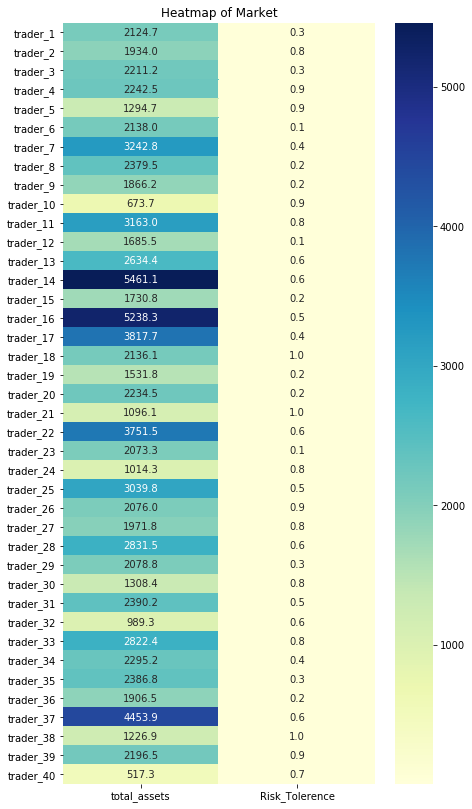

In [158]:
for trader in traders:  
        # displaying trader risk appetites/tolerence
        market.loc[str('trader_' + str(trader.id + 1)), str('Risk_Tolerence')] = trader.appetite


p = market[['total_assets','Risk_Tolerence']]
sub_plot(p.iloc[3:,]) 


## Wealth vs Risk Tolerence — Normalised

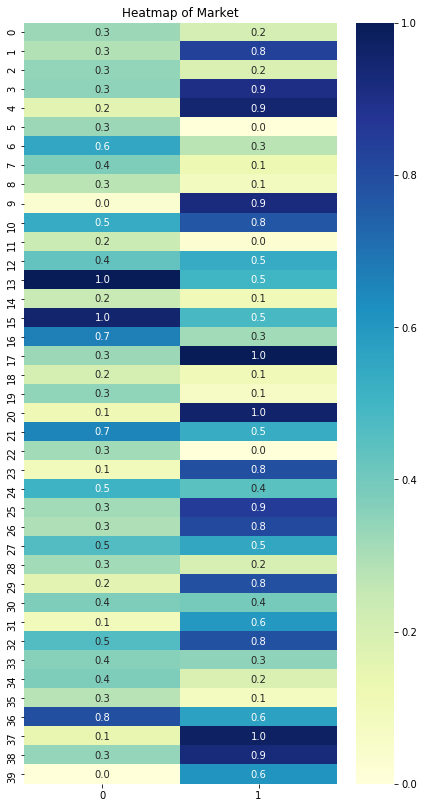

In [163]:
from sklearn import preprocessing

x = p.iloc[3:,].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
sub_plot(df)
